## Import libraries and SVHN dataset

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = SVHN(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


## Architecture

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 64, layers[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Model, functional loss and optimizer

In [3]:
model = ResNet(ResidualBlock, [2, 2, 2])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 10

## Training

In [4]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_accuracy = (correct_train / total_train) * 100
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%")
    
    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    test_epoch_loss = test_running_loss / len(test_loader)
    test_epoch_accuracy = (correct_test / total_test) * 100
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_accuracy)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.2f}%")

Epoch [1/10] - Train Loss: 0.6661, Train Accuracy: 79.07%
Epoch [1/10] - Test Loss: 0.2939, Test Accuracy: 91.38%
Epoch [2/10] - Train Loss: 0.2744, Train Accuracy: 91.88%
Epoch [2/10] - Test Loss: 0.2903, Test Accuracy: 91.15%
Epoch [3/10] - Train Loss: 0.2302, Train Accuracy: 93.26%
Epoch [3/10] - Test Loss: 0.2288, Test Accuracy: 93.59%
Epoch [4/10] - Train Loss: 0.2058, Train Accuracy: 94.07%
Epoch [4/10] - Test Loss: 0.1954, Test Accuracy: 94.38%
Epoch [5/10] - Train Loss: 0.1850, Train Accuracy: 94.73%
Epoch [5/10] - Test Loss: 0.1995, Test Accuracy: 94.41%
Epoch [6/10] - Train Loss: 0.1695, Train Accuracy: 95.16%
Epoch [6/10] - Test Loss: 0.1810, Test Accuracy: 95.04%
Epoch [7/10] - Train Loss: 0.1516, Train Accuracy: 95.67%
Epoch [7/10] - Test Loss: 0.1965, Test Accuracy: 94.51%
Epoch [8/10] - Train Loss: 0.1401, Train Accuracy: 96.01%
Epoch [8/10] - Test Loss: 0.1917, Test Accuracy: 94.56%
Epoch [9/10] - Train Loss: 0.1251, Train Accuracy: 96.41%
Epoch [9/10] - Test Loss: 0.17

## Results

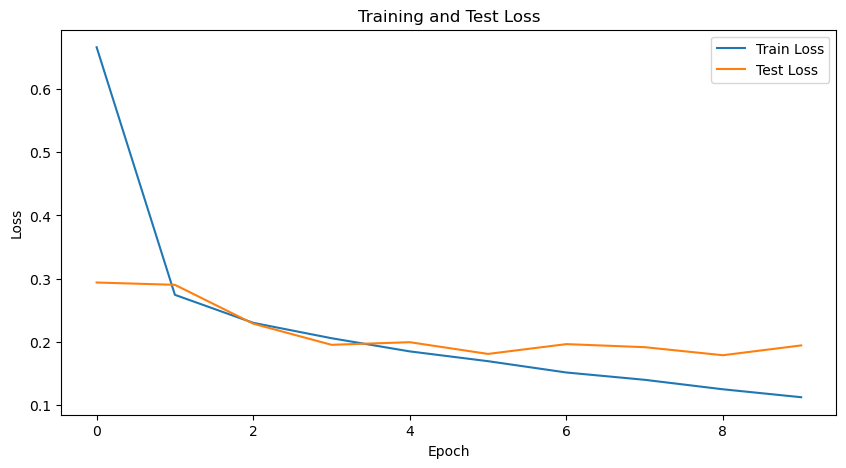

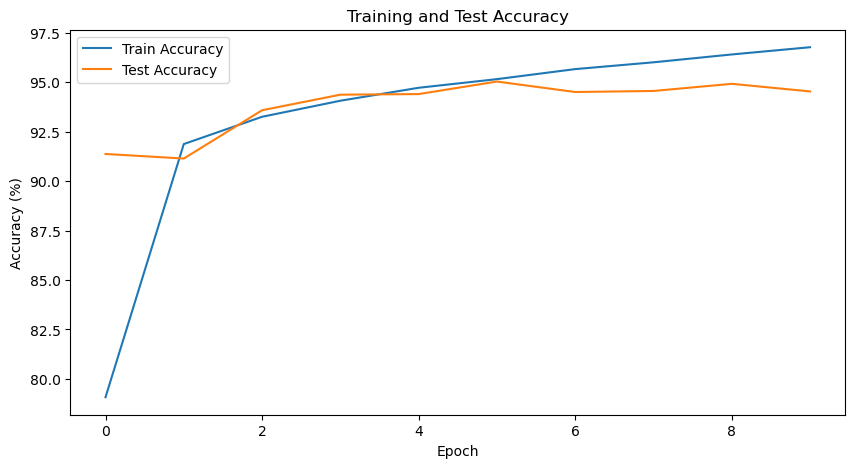

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()